In [1]:
import tensorflow as tf
import numpy as np
import joblib
import os.path
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import os
import shutil
import random
import scipy
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Imported the neccessary libraries 

2023-05-25 15:27:32.626551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 15:27:32.949568: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-25 15:27:32.981654: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-25 15:27:32.981676: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

Load the resnet model from keras

In [2]:
resnet_50_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# a pre-trained ResNet-50 model with the imagenet weights and without the fully connected layer.

2023-05-25 15:27:41.413916: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-25 15:27:41.413990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (divya-Inspiron-15-5518): /proc/driver/nvidia/version does not exist
2023-05-25 15:27:41.415180: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
train_path = 'model_data/train/axial'
valid_path = 'model_data/valid/axial'

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=10, classes=['AD', 'CN'])
 
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=10, classes=['AD', 'CN'], shuffle=False)

### Used the vgg16 prepocesser to preprocess the images which resizes and reshapes the images to feed the model

Found 695 images belonging to 2 classes.
Found 299 images belonging to 2 classes.


In [5]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    # plots a row of 10 images given as input
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    #turns off the axes to display only the image. It then displays the plot

In [6]:
imgs, labels = next(train_batches)

Currently the trainable parameters are: 23,534,592 which is not required for our current task.

In [7]:
resnet_50_model.summary() 
#prints a summary of the ResNet50 model architecture including the layer types, output shapes, and the number of parameters

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

We can see that the model is a Functional API model.

In [8]:
type(resnet_50_model)

keras.engine.functional.Functional

We flatten the input to the model and then pass it to the output layer, which is a new Dense Layer with a two neurons. The output layer is the final layer of the model.

In [9]:
# Flatten output layer of Resnet
flattened = tf.keras.layers.Flatten()(resnet_50_model.output)

#Fully connected layer, output layer
fc2 = tf.keras.layers.Dense(2, activation='sigmoid', name="AddedDense1")(flattened)

model = tf.keras.models.Model(inputs=resnet_50_model.input, outputs=fc2)

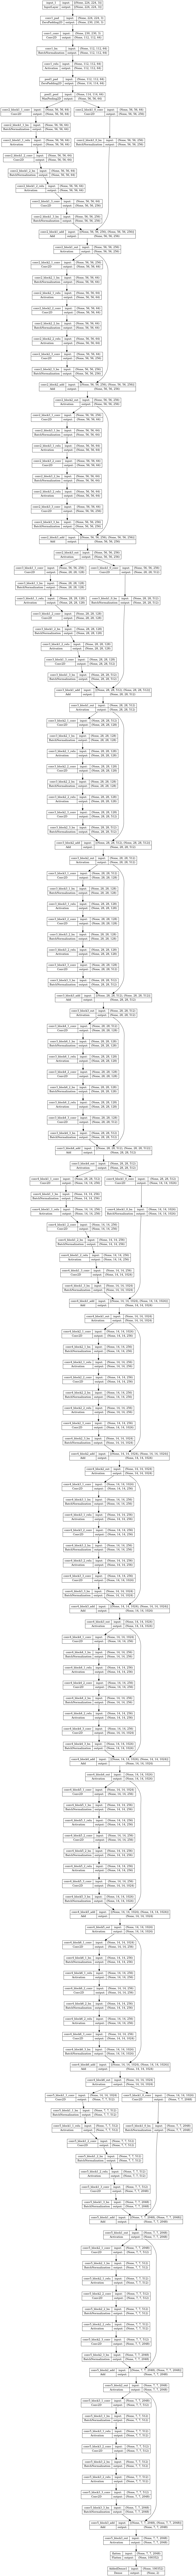

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot_resnet_binary.png', show_shapes=True, show_layer_names=True)

#Print the architechure 

Apart from the 'AddedDense1' Layer that we created, all the rest of the layers are frozen.

In [11]:
for layer in model.layers:
    if layer.name == 'AddedDense1':
        break
    layer.trainable = False

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [13]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

#Adam optimizer with a learning rate of 0.0001, categorical cross-entropy loss function, and accuracy metric to be monitored.

In [14]:
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 20:
        lr *= 0.1
    return lr

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
 #used early stopping to prevent the model from overfitting on the training data 
 #and to improve its performance on the validation data
    min_delta=0,
    patience=3,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

if os.path.isfile('models/adni_resnet.h5'):
    model = load_model('models/adni_resnet.h5')
    history = joblib.load('models/history/adni_resnet.pkl')
else:
    history = model.fit(x=train_batches, steps_per_epoch=train_batches.n//train_batches.batch_size, validation_data=valid_batches, validation_steps=valid_batches.n//valid_batches.batch_size, epochs=50, verbose=2, callbacks=[callback, LearningRateScheduler(lr_schedule)])
    joblib.dump(history, 'models/history/adni_resnet.pkl')
    
    model.save('models/adni_resnet.h5')
    
    #loads the ResNet50 model and applies early stopping and learning rate scheduling callbacks during training. 
    # If a saved model exists, it is loaded, otherwise the model is trained and saved to the file system. 
    # The training history is also saved using joblib.

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-03-08 04:31:56     97223792
metadata.json                                  2023-03-08 04:31:56           64
config.json                                    2023-03-08 04:31:56        85775
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_10
.........vars
......activation_11
.........vars
......activation_12
.........vars
......activation_13
.........vars
......activation_14
.........vars
......activation_15
.........vars
......activation_16
.........vars
......activation_17
.........vars
......activation_18
.........vars
......activation_19
.........vars
......activation_2
.........vars
......activation_20
.........vars
......activation_21
.........vars
......activation_22
.........vars
......activation_23
.........vars
..

# Tracking Convergence

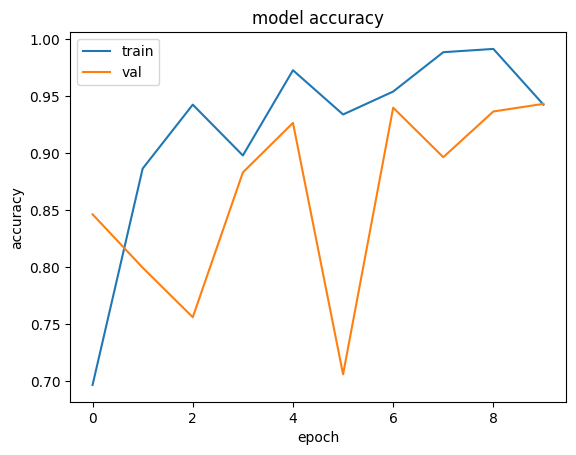

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Plots model accuracy for training and validation data over epochs to visualize performance and detect overfitting/underfitting.

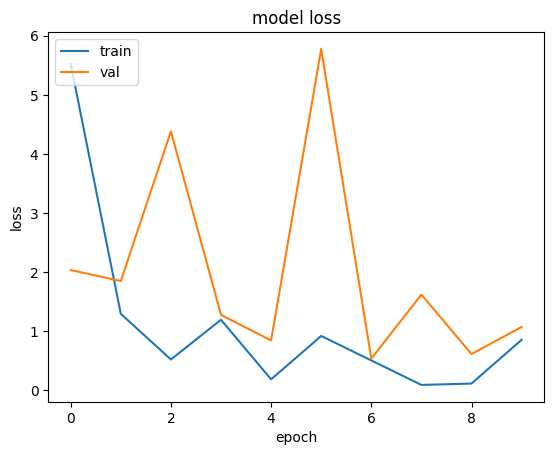

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#plots the training and validation loss of a machine learning model over epochs to visualize overfitting or underfitting.

In [17]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    # plots a grid of 10 images with no axis and sets a tight layout

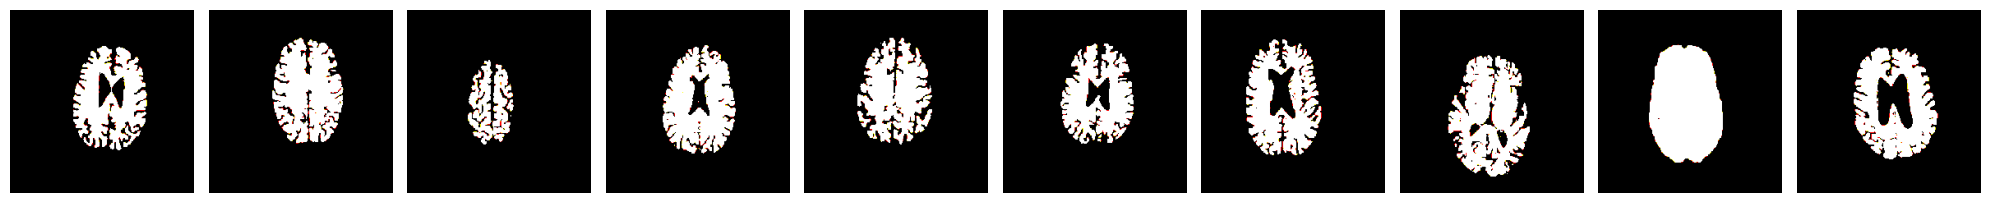

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [18]:
test_imgs, test_labels = next(valid_batches)
plotImages(test_imgs)
print(test_labels)

#Displays a batch of images and their corresponding labels from the validation set.

In [19]:
predictions = model.predict(x=valid_batches, verbose=0)

# generates predictions for a set of data called valid_batches and saves the predictions in a variable named 'predictions' for future evaluation.

In [20]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [21]:
test_imgs, test_labels = next(valid_batches)

In [22]:
test_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [23]:
import os
from tensorflow.keras.preprocessing.image import load_img

# Get the list of file names in the directory
file_names_ad = os.listdir(train_path + "/AD")

# Select the first file name from the list
first_file_name = file_names_ad[0]

# Load the first image
ad = load_img(train_path + "/AD/" + first_file_name)

# Get the list of file names in the directory
file_names_cn = os.listdir(train_path + "/CN")

# Select the first file name from the list
first_file_name = file_names_cn[0]

# Load the first image
cn = load_img(train_path + "/CN/" + first_file_name)


In [24]:
# Preprocess the images using VGG16 preprocessing function
ad_processed = tf.keras.applications.vgg16.preprocess_input(np.array(ad.resize((224, 224))))
cn_processed = tf.keras.applications.vgg16.preprocess_input(np.array(cn.resize((224, 224))))

# Create a batch of size 2 with the processed images
visualize_batch = np.stack([ad_processed, cn_processed])


In [25]:
visualize_batch[0].shape

(224, 224, 3)

In [26]:
len(model.layers)

177

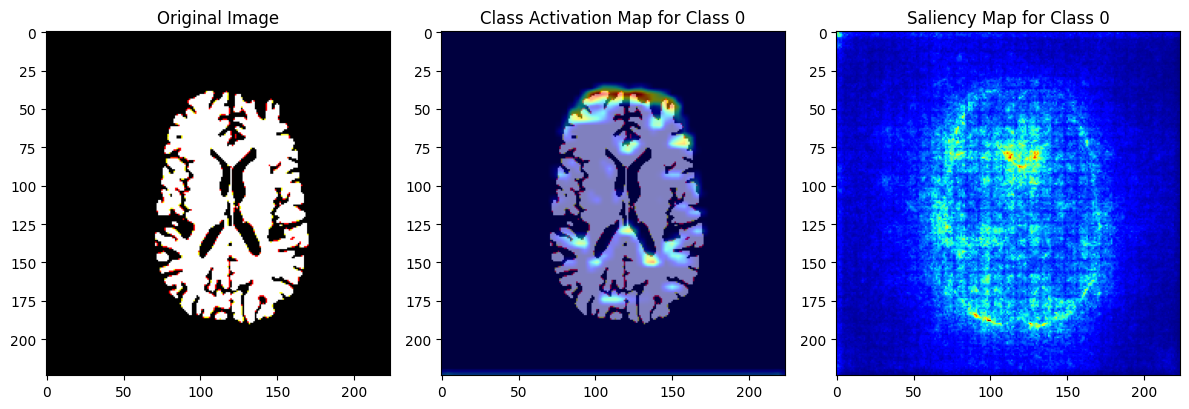

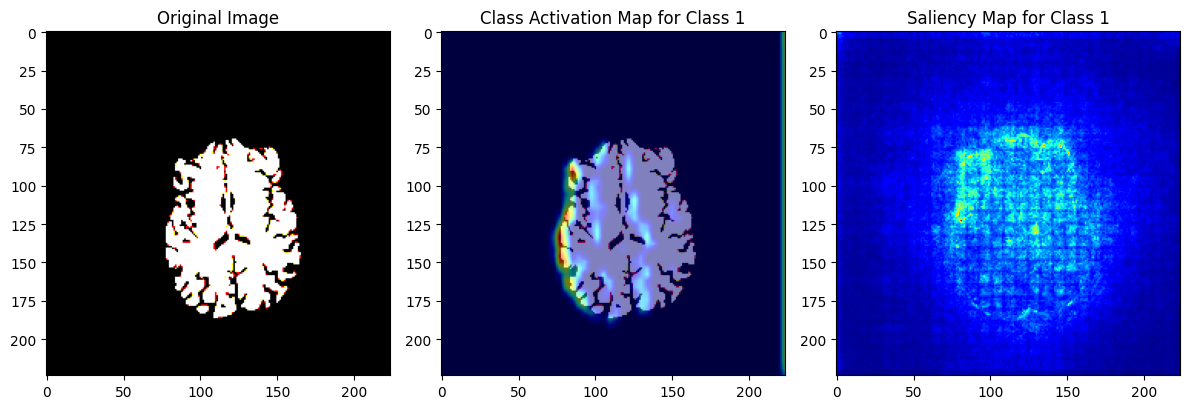

In [27]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
replace2linear = ReplaceToLinear()

# Select an image from the validation set

batch = valid_batches
# gradcam_model = tf.keras.models.Model(
#     [model.inputs], [model.layers[-3].output, model.output]
# )
# Create GradCAM++ object (Gradm a framework)
# Create Gradcam object
gradcam = GradcamPlusPlus(model,
                  model_modifier=replace2linear,
                  clone=True)

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map


# Loop over all classes and generate corresponding heatmaps
for class_index in range(len(valid_batches.class_indices)):
    # error = True
    # image_index = np.where(visualize_batch.classes == class_index)[0][0]
    image = visualize_batch[class_index]
    # Generate cam with GradCAM++
    cam = gradcam(CategoricalScore(class_index), image, penultimate_layer=10)
    saliency_map = saliency(CategoricalScore(class_index), image, smooth_samples=20, smooth_noise=0.20) # noise spread level.)
    
    # Plot the original image and the heatmap
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    axs[1].imshow(image)
    axs[1].imshow(heatmap, alpha=0.5, cmap='jet')
    axs[1].set_title(f'Class Activation Map for Class {class_index}')
    
    axs[2].imshow(saliency_map[0], cmap='jet')
    axs[2].set_title(f'Saliency Map for Class {class_index}')
    plt.tight_layout()
    plt.show()
    
    #plots three images: the original image, the class activation map for a specific class, 
    # and the saliency map for the same class. It uses a jet color map to visualize the activation and saliency maps.


In [28]:
cm = confusion_matrix(y_true=valid_batches.classes, y_pred=np.argmax(predictions, axis=1))
#plotting confusion matrix 

In [29]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
   
    #This function prints and plots the confusion matrix.
    #Normalization can be applied by setting `normalize=True`.

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}%".format(cm[i, j] * 100),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    #plotting a confusion matrix with text annotations showing the percentage of correct predictions for each class
    #The threshold for text color is set to half the maximum value. 
    # The plot is then labeled with the true and predicted labels for the x and y axes, respectively.

In [30]:
valid_batches.class_indices

{'AD': 0, 'CN': 1}

Confusion matrix for the model is shown below, where the diagonal elements are the true positives, the off-diagonal elements are the false positives.

Normalized confusion matrix
[[0.976     0.024    ]
 [0.0862069 0.9137931]]


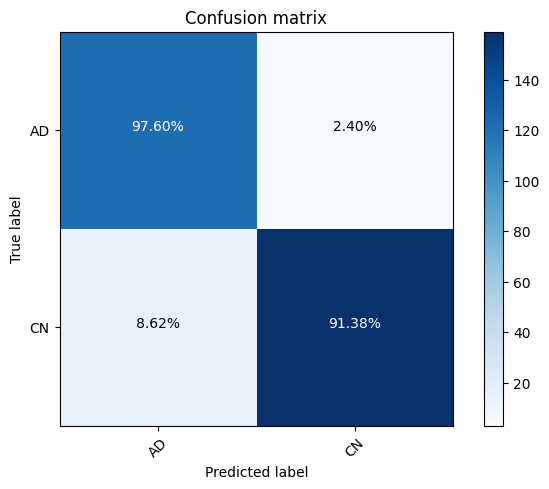

In [31]:
cm_plot_labels = valid_batches.class_indices.keys()
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion matrix', normalize=True)

#Plotting confusion matrix

In [32]:
from sklearn import metrics

print(metrics.classification_report(valid_batches.classes, np.argmax(predictions, axis=-1), target_names=cm_plot_labels))

##generating a report which includes various metrics such as precision, recall, f1-score, and support for each class. 

              precision    recall  f1-score   support

          AD       0.89      0.98      0.93       125
          CN       0.98      0.91      0.95       174

    accuracy                           0.94       299
   macro avg       0.94      0.94      0.94       299
weighted avg       0.94      0.94      0.94       299

